# BÁO CÁO PHÂN TÍCH TOÀN DIỆN: KHÍ HẬU VÀ SỨC KHỎE TOÀN CẦU
**Dữ liệu sử dụng:** GlobalWeatherRepository & Climate Health Impact Tracker  

---
## 🎯 Mục tiêu Phân tích
1. **Phân tích Khí hậu:** Sử dụng dữ liệu trạm đo để tìm ra các kiểu thời tiết phổ biến và yếu tố chi phối nhiệt độ.
2. **Phân tích Sức khỏe:** Kết nối sự biến đổi khí hậu với các hội chứng sốc nhiệt và rủi ro dịch bệnh.
3. **Mô hình Dự báo:** Thẩm định khả năng dự báo rủi ro dựa trên kịch bản thời tiết giả lập.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cấu hình giao diện
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 15

In [ ]:
# 1. Tải dữ liệu
try:
    # File 1: Dữ liệu thời tiết chi tiết
    df_weather = pd.read_csv('data/GlobalWeatherRepository.csv')
    # File 2: Dữ liệu tác động sức khỏe
    df_health = pd.read_csv('data/global_climate_health_impact_tracker_2015_2025.csv')
    
    print(f"✅ Tải thành công Weather Data: {df_weather.shape[0]} dòng")
    print(f"✅ Tải thành công Health Data: {df_health.shape[0]} dòng")
except FileNotFoundError as e:
    print(f"❌ Lỗi: Không tìm thấy file. Chi tiết: {e}")

✅ Tải thành công Weather Data: 120042 dòng
✅ Tải thành công Health Data: 14100 dòng


## 1. PHÂN TÍCH CÁC YẾU TỐ KHÍ TƯỢNG
Chúng ta sẽ tìm hiểu xem điều gì đang thực sự xảy ra với bầu khí quyển thông qua dữ liệu từ các trạm quan trắc.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4948\1809199951.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_conditions.values, y=top_conditions.index, palette='viridis')


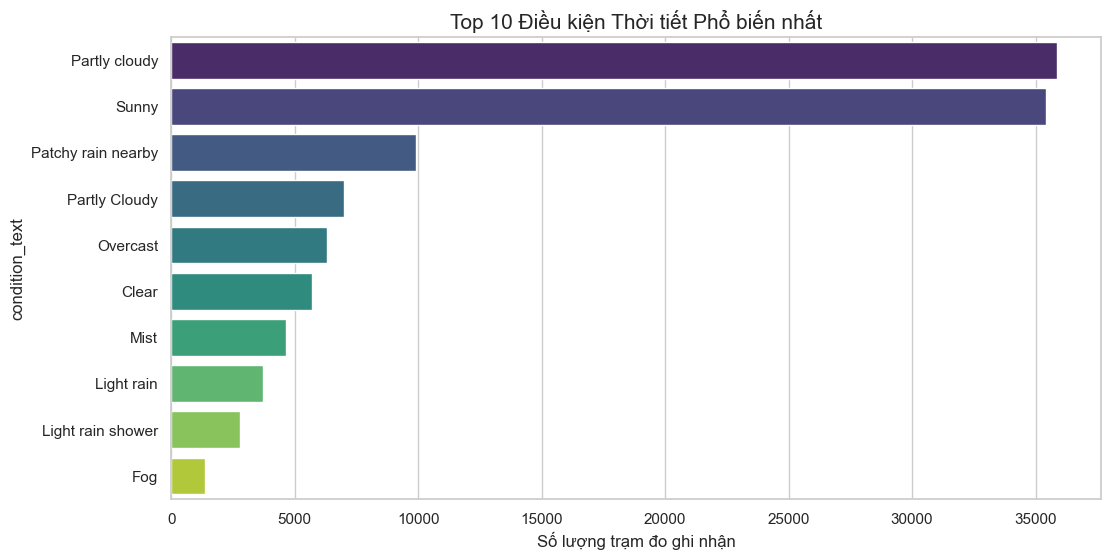

In [3]:
# 1.1 Top 10 điều kiện thời tiết phổ biến nhất thế giới
plt.figure(figsize=(12, 6))
top_conditions = df_weather['condition_text'].value_counts().head(10)
sns.barplot(x=top_conditions.values, y=top_conditions.index, palette='viridis')
plt.title('Top 10 Điều kiện Thời tiết Phổ biến nhất')
plt.xlabel('Số lượng trạm đo ghi nhận')
plt.show()

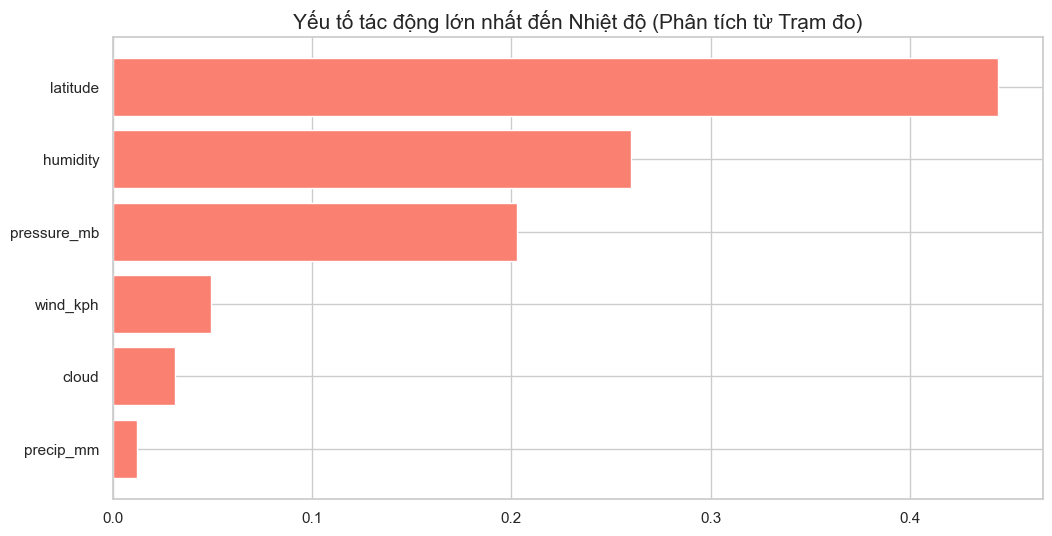

Nhận xét: Vĩ độ và Độ ẩm là những biến số chi phối nhiệt độ mạnh nhất.


In [4]:
# 1.2 Yếu tố nào ảnh hưởng đến Nhiệt độ nhất?
# Chọn các cột cảm biến từ GlobalWeatherRepository
features = ['humidity', 'pressure_mb', 'wind_kph', 'cloud', 'precip_mm', 'latitude']
X = df_weather[features].fillna(0)
y = df_weather['temperature_celsius']

model_rf = RandomForestRegressor(n_estimators=50, random_state=42)
model_rf.fit(X, y)

# Vẽ biểu đồ mức độ quan trọng
imp_df = pd.DataFrame({'Yếu tố': features, 'Mức độ ảnh hưởng': model_rf.feature_importances_}).sort_values('Mức độ ảnh hưởng')
plt.barh(imp_df['Yếu tố'], imp_df['Mức độ ảnh hưởng'], color='salmon')
plt.title('Yếu tố tác động lớn nhất đến Nhiệt độ (Phân tích từ Trạm đo)')
plt.show()
print("Nhận xét: Vĩ độ và Độ ẩm là những biến số chi phối nhiệt độ mạnh nhất.")

## 2. SỐC NHIỆT
Sử dụng dữ liệu Health Impact để phân tích ngưỡng chịu đựng của con người khi nhiệt độ tăng cao.

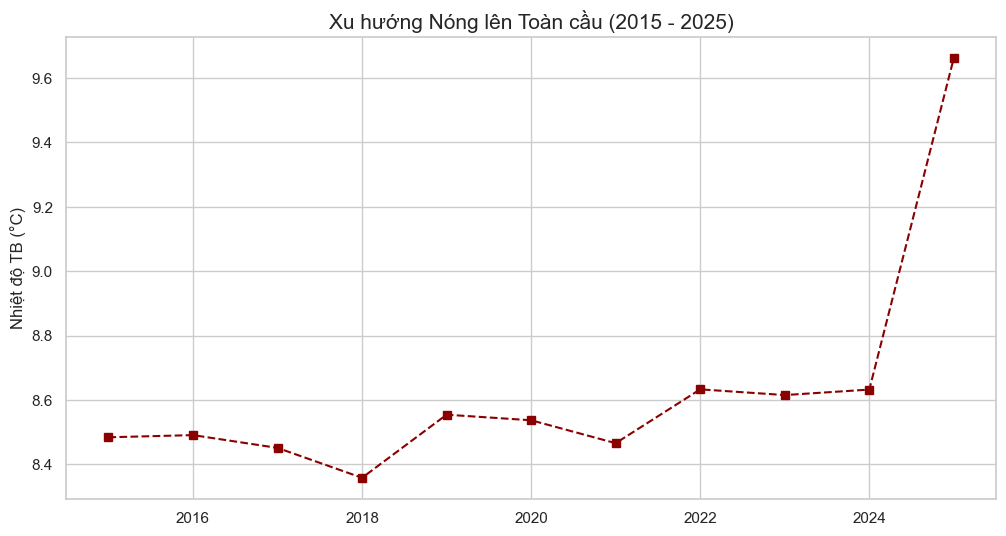

In [5]:
# 2.1 Biểu đồ xu hướng nhiệt độ toàn cầu qua các năm
yearly_temp = df_health.groupby('year')['temperature_celsius'].mean()
plt.plot(yearly_temp.index, yearly_temp.values, marker='s', color='darkred', linestyle='--')
plt.title('Xu hướng Nóng lên Toàn cầu (2015 - 2025)')
plt.ylabel('Nhiệt độ TB (°C)')
plt.show()

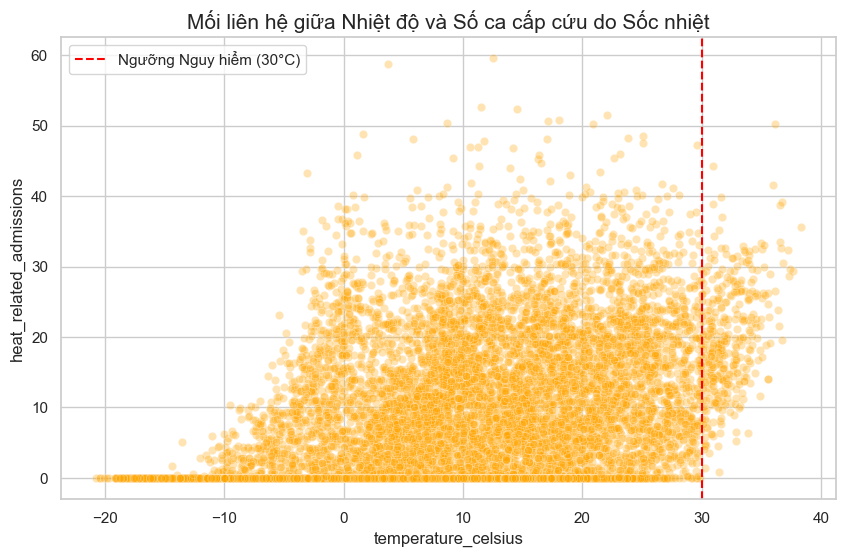

Nhận xét: Sau mốc 30°C, số ca nhập viện tăng vọt, chứng tỏ đây là giới hạn chịu nhiệt của cơ thể.


In [6]:
# 2.2 Phân tích Sốc nhiệt: Tìm ngưỡng gãy (Tipping Point)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_health, x='temperature_celsius', y='heat_related_admissions', alpha=0.3, color='orange')
plt.axvline(x=30, color='red', linestyle='--', label='Ngưỡng Nguy hiểm (30°C)')
plt.title('Mối liên hệ giữa Nhiệt độ và Số ca cấp cứu do Sốc nhiệt')
plt.legend()
plt.show()
print("Nhận xét: Sau mốc 30°C, số ca nhập viện tăng vọt, chứng tỏ đây là giới hạn chịu nhiệt của cơ thể.")

## 3. DỊCH BỆNH TRUYỀN NHIỄM
Phân tích xem tại sao sự kết hợp giữa nắng nóng và mưa nhiều lại tạo ra các ổ dịch.

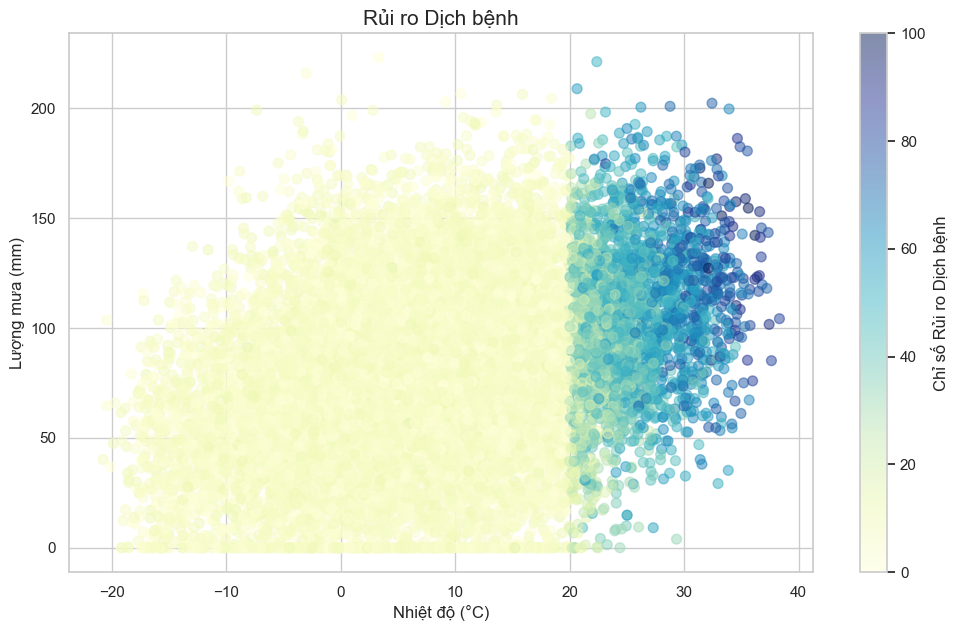

In [14]:
# 3.1 Ma trận rủi ro: Nhiệt độ & Lượng mưa
plt.figure(figsize=(12, 7))
plt.scatter(df_health['temperature_celsius'], df_health['precipitation_mm'], 
            c=df_health['vector_disease_risk_score'], cmap='YlGnBu', alpha=0.5, s=50)
plt.colorbar(label='Chỉ số Rủi ro Dịch bệnh')
plt.xlabel('Nhiệt độ (°C)')
plt.ylabel('Lượng mưa (mm)')
plt.title('Rủi ro Dịch bệnh')
plt.show()